**MNIST/SVHN - DOMAIN ADAPTATION <br>
(version PYTORCH)**
---
PROJET COMPUTER VISION

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

In [34]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)

from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)


Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat


In [35]:
# DATASET STRUCTURE
print('train_dataset structure',dir(train_dataset_source))
print('train_dataset length:',len(train_dataset_source),type(train_dataset_source))
print('test_dataset length:',len(test_dataset_source),type(test_dataset_source))
print('images shape:',train_dataset_source[0][0].shape, type(train_dataset_source[0][0]))
labels = torch.unique(train_dataset_source.targets)
print('labels:', labels,type(train_dataset_source[0][1]), type(train_dataset_source.targets), type(train_dataset_source))

train_dataset structure ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
train_dataset length: 60000 <class 'torchvision.datasets.mnist.MNIST'>
test_dataset length

In [36]:
# Data Loader (Input Pipeline)
bs = 64 # batch size
source_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs, shuffle=True)
source_loader_train = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs, shuffle=False)

target_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs, shuffle=True)
target_loader_train = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs, shuffle=False)

**0/ Data exploration**
---

In [37]:
# CHECK ORGINAL DATASET FORMATS
#------------------------------

# MNIST dataset dimension
print('!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!\n','!'*110)
print('dimension of X_train_source:',train_dataset_source.data.shape)
print('dimension of X_test_source:',test_dataset_source.data.shape)
mnist_data_train = train_dataset_source.data  # Convert to float for min/max calculation
print('MNIST data type:',type(mnist_data_train))
print('MNIST pixel value range (train):',mnist_data_train.float().min().item(),mnist_data_train.float().max().item())
mnist_data_test = test_dataset_source.data  # Convert to float for min/max calculation
print('MNIST pixel value range (test):',mnist_data_test.float().min().item(),mnist_data_test.float().max().item())

# SVHN dataset dimension
print('\ndimension of X_train_target:',train_dataset_target.data.shape)
print('dimension of X_test_target:',test_dataset_target.data.shape)
svhn_data_train = train_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN data type:',type(svhn_data_train))
print('SVHN pixel value range (train):',svhn_data_train.min().item(),svhn_data_train.max().item())
svhn_data_test = test_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN pixel value range (test):',svhn_data_test.min().item(),svhn_data_test.max().item())


!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dimension of X_train_source: torch.Size([60000, 28, 28])
dimension of X_test_source: torch.Size([10000, 28, 28])
MNIST data type: <class 'torch.Tensor'>
MNIST pixel value range (train): 0.0 255.0
MNIST pixel value range (test): 0.0 255.0

dimension of X_train_target: (73257, 3, 32, 32)
dimension of X_test_target: (26032, 3, 32, 32)
SVHN data type: <class 'numpy.ndarray'>
SVHN pixel value range (train): 0 255
SVHN pixel value range (test): 0 255


In [38]:
# Retrieve the first batch and check the dimensions

# MNIST
print('MNIST\ndimension of dataloader:',len(source_loader_train),type(source_loader_train  ))
first_batch_data, first_batch_labels = next(iter(source_loader_train))

print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

# SVHN
print('\nSVHN\ndimension of dataloader:',len(target_loader_train),type(target_loader_train  ))
first_batch_data, first_batch_labels = next(iter(target_loader_train))
print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

MNIST
dimension of dataloader: 157 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -1.0 max: 1.0
dimension of dataloader 1st batch for labels: torch.Size([64]) <class 'torch.Tensor'>

SVHN
dimension of dataloader: 407 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -0.9764705896377563 max: 1.0
dimension of dataloader 1st batch for labels: torch.Size([64]) <class 'torch.Tensor'>


/tmp/ipykernel_7500/2398454321.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ys_train = torch.tensor(train_dataset_source.targets)


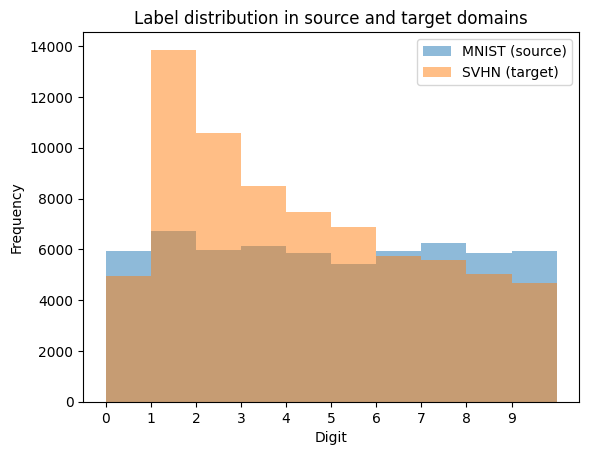

/tmp/ipykernel_7500/2398454321.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ys_test = torch.tensor(test_dataset_source.targets)


weights_source: tensor([10.1000,  8.9000, 10.1000,  9.8000, 10.3000, 11.1000, 10.1000,  9.6000,
        10.3000, 10.1000])
weights_target (for information only): tensor([14.8000,  5.3000,  6.9000,  8.6000,  9.8000, 10.6000, 12.8000, 13.1000,
        14.5000, 15.7000])


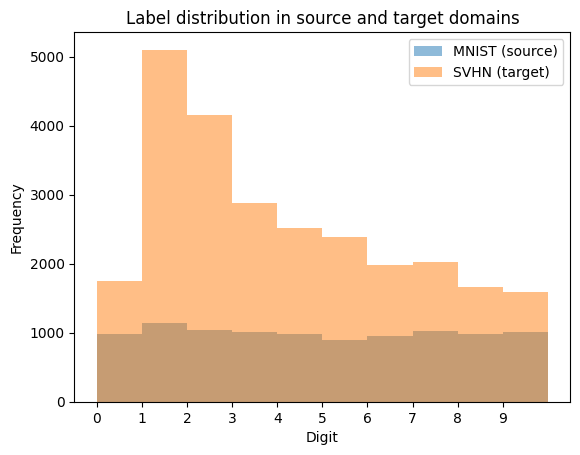

In [40]:
# SHOW TRAIN DISTRIBUTIONS
#-------------------------

# Extract labels
Ys_train = torch.tensor(train_dataset_source.targets)
Yt_train = torch.tensor(train_dataset_target.labels)

# Plotting
plt.hist(Ys_train.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
plt.hist(Yt_train.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
plt.xlabel('Digit')
plt.xticks(range(10))
plt.ylabel('Frequency')
plt.legend()
plt.title('Label distribution in source and target domains')
plt.show()

# Calculate weights for the loss function
# Source domain (MNIST)
label_frequency_source = torch.bincount(Ys_train) / len(Ys_train)
weights_source = 1.0 / label_frequency_source
print('weights_source:', torch.round(weights_source, decimals=1))

# Target domain (SVHN)
label_frequency_target = torch.bincount(Yt_train) / len(Yt_train)
weights_target = 1.0 / label_frequency_target
print('weights_target (for information only):', torch.round(weights_target, decimals=1))

# SHOW TEST DISTRIBUTIONS
#------------------------

# Extract labels
Ys_test = torch.tensor(test_dataset_source.targets)
Yt_test = torch.tensor(test_dataset_target.labels)

# Plotting
plt.hist(Ys_test.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
plt.hist(Yt_test.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
plt.xlabel('Digit')
plt.xticks(range(10))
plt.ylabel('Frequency')
plt.legend()
plt.title('Label distribution in source and target domains')
plt.show()

